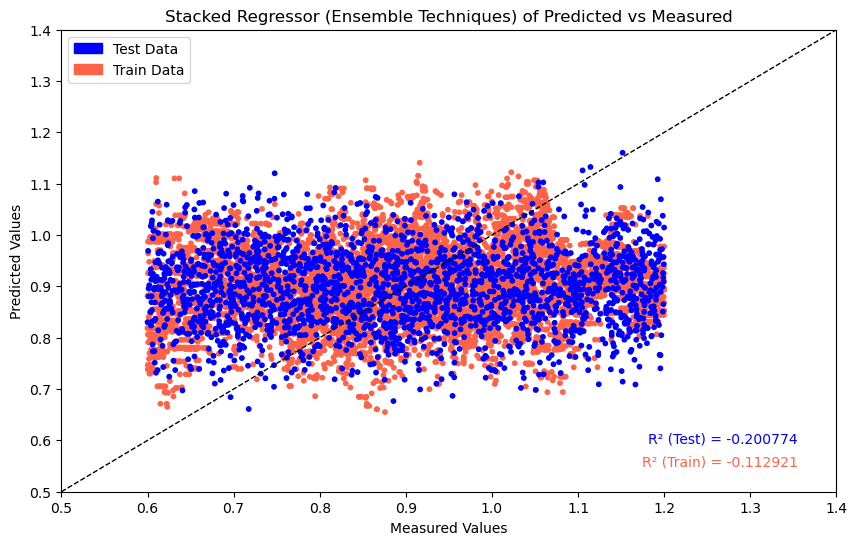

In [2]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import NuSVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches

# Load your data 
data = pd.read_csv('GAN/new_test_data.csv')

# Select relevant features and target variable
selected_features = ['T (K)', 'P (MPa)', 'methane', 'ethane',
                     'propane', 'butane', 'pentane', 'ipentane', 'hexane',
                     'heptane', 'octane', 'nonane', 'decane', 'helium', 'oxygen',
                     'nitrogen', 'water', 'argon','hydrogen',
                     'H2S', 'CO2',]
target_variable = 'z'
X = data[selected_features]
y = data[target_variable]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define individual regressor models
wknn = KNeighborsRegressor(n_neighbors=5, weights='distance')
sgdboost = GradientBoostingRegressor(random_state=42)
gpr = GaussianProcessRegressor(random_state=42)
adaboost = AdaBoostRegressor(random_state=42)
nu_svr = NuSVR()

# Create a stacked regressor with the defined models
estimators = [
    ('wknn', wknn),
    ('sgdboost', sgdboost),
    ('gpr', gpr),
    ('adaboost', adaboost),
    ('nu_svr', nu_svr)
]
stacked_regressor = StackingRegressor(estimators=estimators, final_estimator=KNeighborsRegressor())

# Fit the stacked regressor to the training data
stacked_regressor.fit(X_train, y_train)

# Make predictions on the test set and training set
y_pred_test = stacked_regressor.predict(X_test)
y_pred_train = stacked_regressor.predict(X_train)

# Calculate R-squared for evaluation
r2_test = r2_score(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)

# Plotting predicted vs measured with different colors
fig, ax = plt.subplots(figsize=(10, 6))

# set the limits of x-axis and y-axis from 0.5 to 1.5
ax.set_xlim(0.5, 1.4)
ax.set_ylim(0.5, 1.4)

# Scatter plot for y_train vs y_train_pred with different colors for train data
predicted_colors_train = ['tomato' if pred >= actual else 'tomato' for pred, actual in zip(y_pred_train, y_train)]
pred_actual_scatter_train = ax.scatter(y_train, y_pred_train, c=predicted_colors_train, marker=".", s=40, label='Train Data')

# Scatter plot for predicted vs measured with different colors for test data
predicted_colors_test = ['blue' if pred >= actual else 'blue' for pred, actual in zip(y_pred_test, y_test)]
pred_actual_scatter_test = ax.scatter(y_test, y_pred_test, c=predicted_colors_test, marker=".", s=40)

# Plot line of equality with grey color and dashed style
ax.plot([0.5, 1.4], [0.5, 1.4], color='black', linestyle='--', lw=1, label='Line of Equality')

# Legends for distinguishing predicted and actual markers for test and train data
overprediction_patch = mpatches.Patch(color='blue', label='Test Data')
underprediction_train_patch = mpatches.Patch(color='tomato', label='Train Data')

# Annotation for R-squared values on the plot at the bottom right
ax.text(0.95, 0.05, f'R\u00b2 (Train) = {r2_train:.6f}', transform=ax.transAxes,
        fontsize=10, color='tomato', ha='right', va='bottom')
ax.text(0.95, 0.1, f'R\u00b2 (Test) = {r2_test:.6f}', transform=ax.transAxes,
        fontsize=10, color='blue', ha='right', va='bottom')

# Create the legend
legend_elements = [
    overprediction_patch,
    underprediction_train_patch,
]

# Set plot title and labels
ax.set_title('Stacked Regressor (Ensemble Techniques) of Predicted vs Measured')
ax.set_xlabel('Measured Values')
ax.set_ylabel('Predicted Values')

# Create the legend
plt.legend(handles=legend_elements)

# Show the plot
plt.show()


In [3]:
# Create DataFrame for training data
train_results = pd.DataFrame({
    'Data Type': 'Train',
    'Actual z': y_train,
    'Predicted z': y_pred_train
})

# Create DataFrame for testing data
test_results = pd.DataFrame({
    'Data Type': 'Test',
    'Actual z': y_test,
    'Predicted z': y_pred_test
})

# Concatenate the training and testing data
model_results = pd.concat([train_results, test_results], ignore_index=True)

# Export the DataFrame to an Excel file
model_results.to_excel("Super Learner compositional data results.xlsx", index=False)


In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Ensure both y_test and y_pred have the same length for test data
y_test = y_test[:len(y_pred_test)]
y_pred = y_pred_test[:len(y_test)]

# Ensure both y_train and y_pred_train have the same length for train data
y_train = y_train[:len(y_pred_train)]
y_pred_train = y_pred_train[:len(y_train)]

# Calculate evaluation metrics for test data
mae_test = mean_absolute_error(y_test, y_pred)
mape_test = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate evaluation metrics for train data
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)

# Print the evaluation metrics for test data
print("Evaluation Metrics for Test Data:")
print(f'Mean Absolute Error (MAE): {mae_test:.9f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_test:.9f}%')
print(f'Root Mean Squared Error (RMSE): {rmse_test:.9f}')
print(f'R\u00b2 Value: {r2_test:.9f}')

# Print the evaluation metrics for train data
print("\nEvaluation Metrics for Train Data:")
print(f'Mean Absolute Error (MAE): {mae_train:.9f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_train:.9f}%')
print(f'Root Mean Squared Error (RMSE): {rmse_train:.9f}')
print(f'R\u00b2 Value: {r2_train:.9f}')


Evaluation Metrics for Test Data:
Mean Absolute Error (MAE): 0.156654290
Mean Absolute Percentage Error (MAPE): 18.440375223%
Root Mean Squared Error (RMSE): 0.186362111
R² Value: -0.200773564

Evaluation Metrics for Train Data:
Mean Absolute Error (MAE): 0.154564435
Mean Absolute Percentage Error (MAPE): 18.195331717%
Root Mean Squared Error (RMSE): 0.182840628
R² Value: -0.112920960


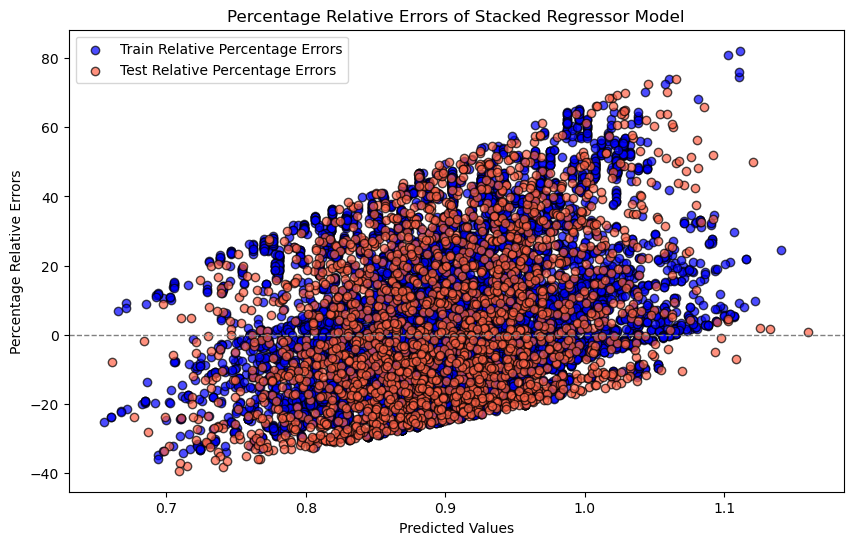

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have your y_pred_train, y_train, y_pred_test, and y_test arrays

# Calculate residuals for the training data
residuals_train_stacked = ((y_pred_train - y_train) / y_train) * 100

# Ensure lengths of y_pred_test and y_test match or resize y_pred_test to match the length of y_test
y_pred_test = y_pred_test[:len(y_test)] if len(y_pred_test) > len(y_test) else y_pred_test

# Calculate residuals for the testing data
residuals_test_stacked = ((y_pred_test - y_test) / y_test) * 100

# Separate residuals into overprediction and underprediction categories for the training data
over_prediction_train_stacked = y_pred_train[(residuals_train_stacked > 0) & (residuals_train_stacked != np.inf)]
under_prediction_train_stacked = y_pred_train[(residuals_train_stacked <= 0) & (residuals_train_stacked != -np.inf)]

# Separate residuals into overprediction and underprediction categories for the testing data
over_prediction_test_stacked = y_pred_test[(residuals_test_stacked > 0) & (residuals_test_stacked != np.inf)]
under_prediction_test_stacked = y_pred_test[(residuals_test_stacked <= 0) & (residuals_test_stacked != -np.inf)]

# Plotting residuals for both training and testing data
plt.figure(figsize=(10, 6))

# Plotting overpredictions in blue and underpredictions in orange for the training data
plt.scatter(over_prediction_train_stacked, residuals_train_stacked[residuals_train_stacked > 0], c='blue', marker='o', edgecolor='black', alpha=0.7, label='Train Relative Percentage Errors')
plt.scatter(under_prediction_train_stacked, residuals_train_stacked[residuals_train_stacked <= 0], c='blue', marker='o', edgecolor='black', alpha=0.7, )

# Plotting overpredictions in red and underpredictions in tomato for the testing data
plt.scatter(over_prediction_test_stacked, residuals_test_stacked[residuals_test_stacked > 0], c='tomato', marker='o', edgecolor='black', alpha=0.7, label='Test Relative Percentage Errors')
plt.scatter(under_prediction_test_stacked, residuals_test_stacked[residuals_test_stacked <= 0], c='tomato', marker='o', edgecolor='black', alpha=0.7, )

plt.xlabel('Predicted Values')
plt.ylabel('Percentage Relative Errors')
plt.title('Percentage Relative Errors of Stacked Regressor Model')

# Adding a horizontal line at y=0
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)

# Show legends
plt.legend()

# Show the plot
plt.show()
